In [16]:
import os.path
import os
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib
import matplotlib.pyplot as plt # this is used for the plot the graph 
from matplotlib import pyplot as plt, patches
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from scipy.signal import argrelextrema, resample

## for Deep-learing:

import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential, model_from_json
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM, CuDNNLSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

# time series
from datetime import datetime, timedelta
%config InlineBackend.figure_format = 'retina'
plt.rcParams['agg.path.chunksize'] = 10000

In [17]:
!pip install tensorflow-gpu

In [18]:
tf.__version__

'1.13.1'

In [19]:
# !pip install scikit-learn keras

### Plotting params

In [20]:
sns.set(style="whitegrid") # set seaborn for pretty plots
#plt.rc('legend', fontsize=12) # legend fontsize

### Data munging functions
A bunch of helpers

In [21]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [22]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=500, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [23]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# Note this function operates on the rolling average, not the raw force, to prevent noisy points from interfering.
def get_extrema(df, order=2000, ra=False):
    col = 'f_ra' if ra else 'f'
    maxima = argrelextrema(df[col].values, np.greater, order=order)
    minima = argrelextrema(df[col].values, np.less, order=order)
    return minima, maxima

In [24]:
# Labels cycles based on local (force) minima and maxima.
# Points not belonging to a valid cycle, e.g. at start and end of experiment,
# are labeled with <cycle# = -1>.
def label_cycles(df, minima, maxima, ax=None, abs_min=None, abs_max=None, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    if not ax:
        fig, ax = plt.subplots(figsize=(25, 6), nrows=1, ncols=1)
    if abs_min and abs_max:
        ax.plot(df.f, alpha=0.3)
        ax.plot(df.f.iloc[abs_max[0].tolist()], '--')
        ax.plot(df.f.iloc[abs_min[0].tolist()], '--')

    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here. I spent 1.5 hours on this bug.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(
                patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='black', facecolor='none', alpha=0.2, linestyle=':')
            )
    df.cycle = df.cycle.astype(np.int64) # Just to be safe
    return df

In [25]:
# Squashes periods down to a constant for all rows in a dataset.
# You can set the desired period with param `period`.
# If you don't, the function just chooses the shortest period.
def squash_periods(df, period=-1, plot_cycles=True):
    c_to_p = {} # maps cycles to their periods
    columns=["f", "pwm", "t", "t0", "f_ra", "cycle", "timestamp"]
    fig, ax = plt.subplots(figsize=(25, 12), nrows=1, ncols=1)
    df.cycle, X = df.cycle.astype(np.int64), pd.DataFrame(columns=columns)
        
    for c in range(df.cycle.max()):
        c_to_p[c] = df[df.cycle==c].shape[0]
    if period<0:
        period = int(min(c_to_p.values()))

    for c in range(df.cycle.max()):
        C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
        C.cycle = c
        X = pd.concat([X, C], ignore_index=True)
        if plot_cycles:
            ax.plot(C.f_ra, color=plt.cm.RdYlBu(c/df.cycle.max()))
    X.timestamp = df.timestamp.iloc[:X.timestamp.size,]
    
    if plot_cycles:
        cmap = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=df.cycle.max()),
            cmap=plt.get_cmap('RdYlBu', df.cycle.max())
        )
        cmap.set_array([])
        plt.colorbar(cmap, orientation="horizontal", pad=0.1)
        
    return X, c_to_p

### Run data munging

In [26]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
X100 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-11-16-21-07-24.msgpack"))), window=150)
X100.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True) # clean up unnecessary columns

In [27]:
X61 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-12-18-21-34.msgpack"))), window=150)
X61.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True) # clean up unnecessary columns

In [28]:
def plot_raw(df, n_cycles=103,savfig = False):
    # one figure / two charts
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    fig.suptitle('Raw measurements, %d cycles' % 103)

    # top chart
    ax.flat[0].plot(df.f, alpha=0.8, label='Force'); ax2 = ax.flat[0].twinx()
    ax2.plot(df.pwm, c='r', alpha=0.3, label='PWM')
    ax.flat[0].legend(bbox_to_anchor=(0.957,0.45)); ax2.legend(bbox_to_anchor=(1,0.5))

    # bottom chart
    ax.flat[1].plot(df.t, label='muscle temperature (°C)'); ax.flat[1].plot(df.t-df.t0, label='Muscle temperature difference (°C)')
    ax.flat[1].legend()
    plt.tight_layout()
    if bool(savfig):
        plt.savefig('plots/%s.png'%savfig,dpi=300)
    plt.show()

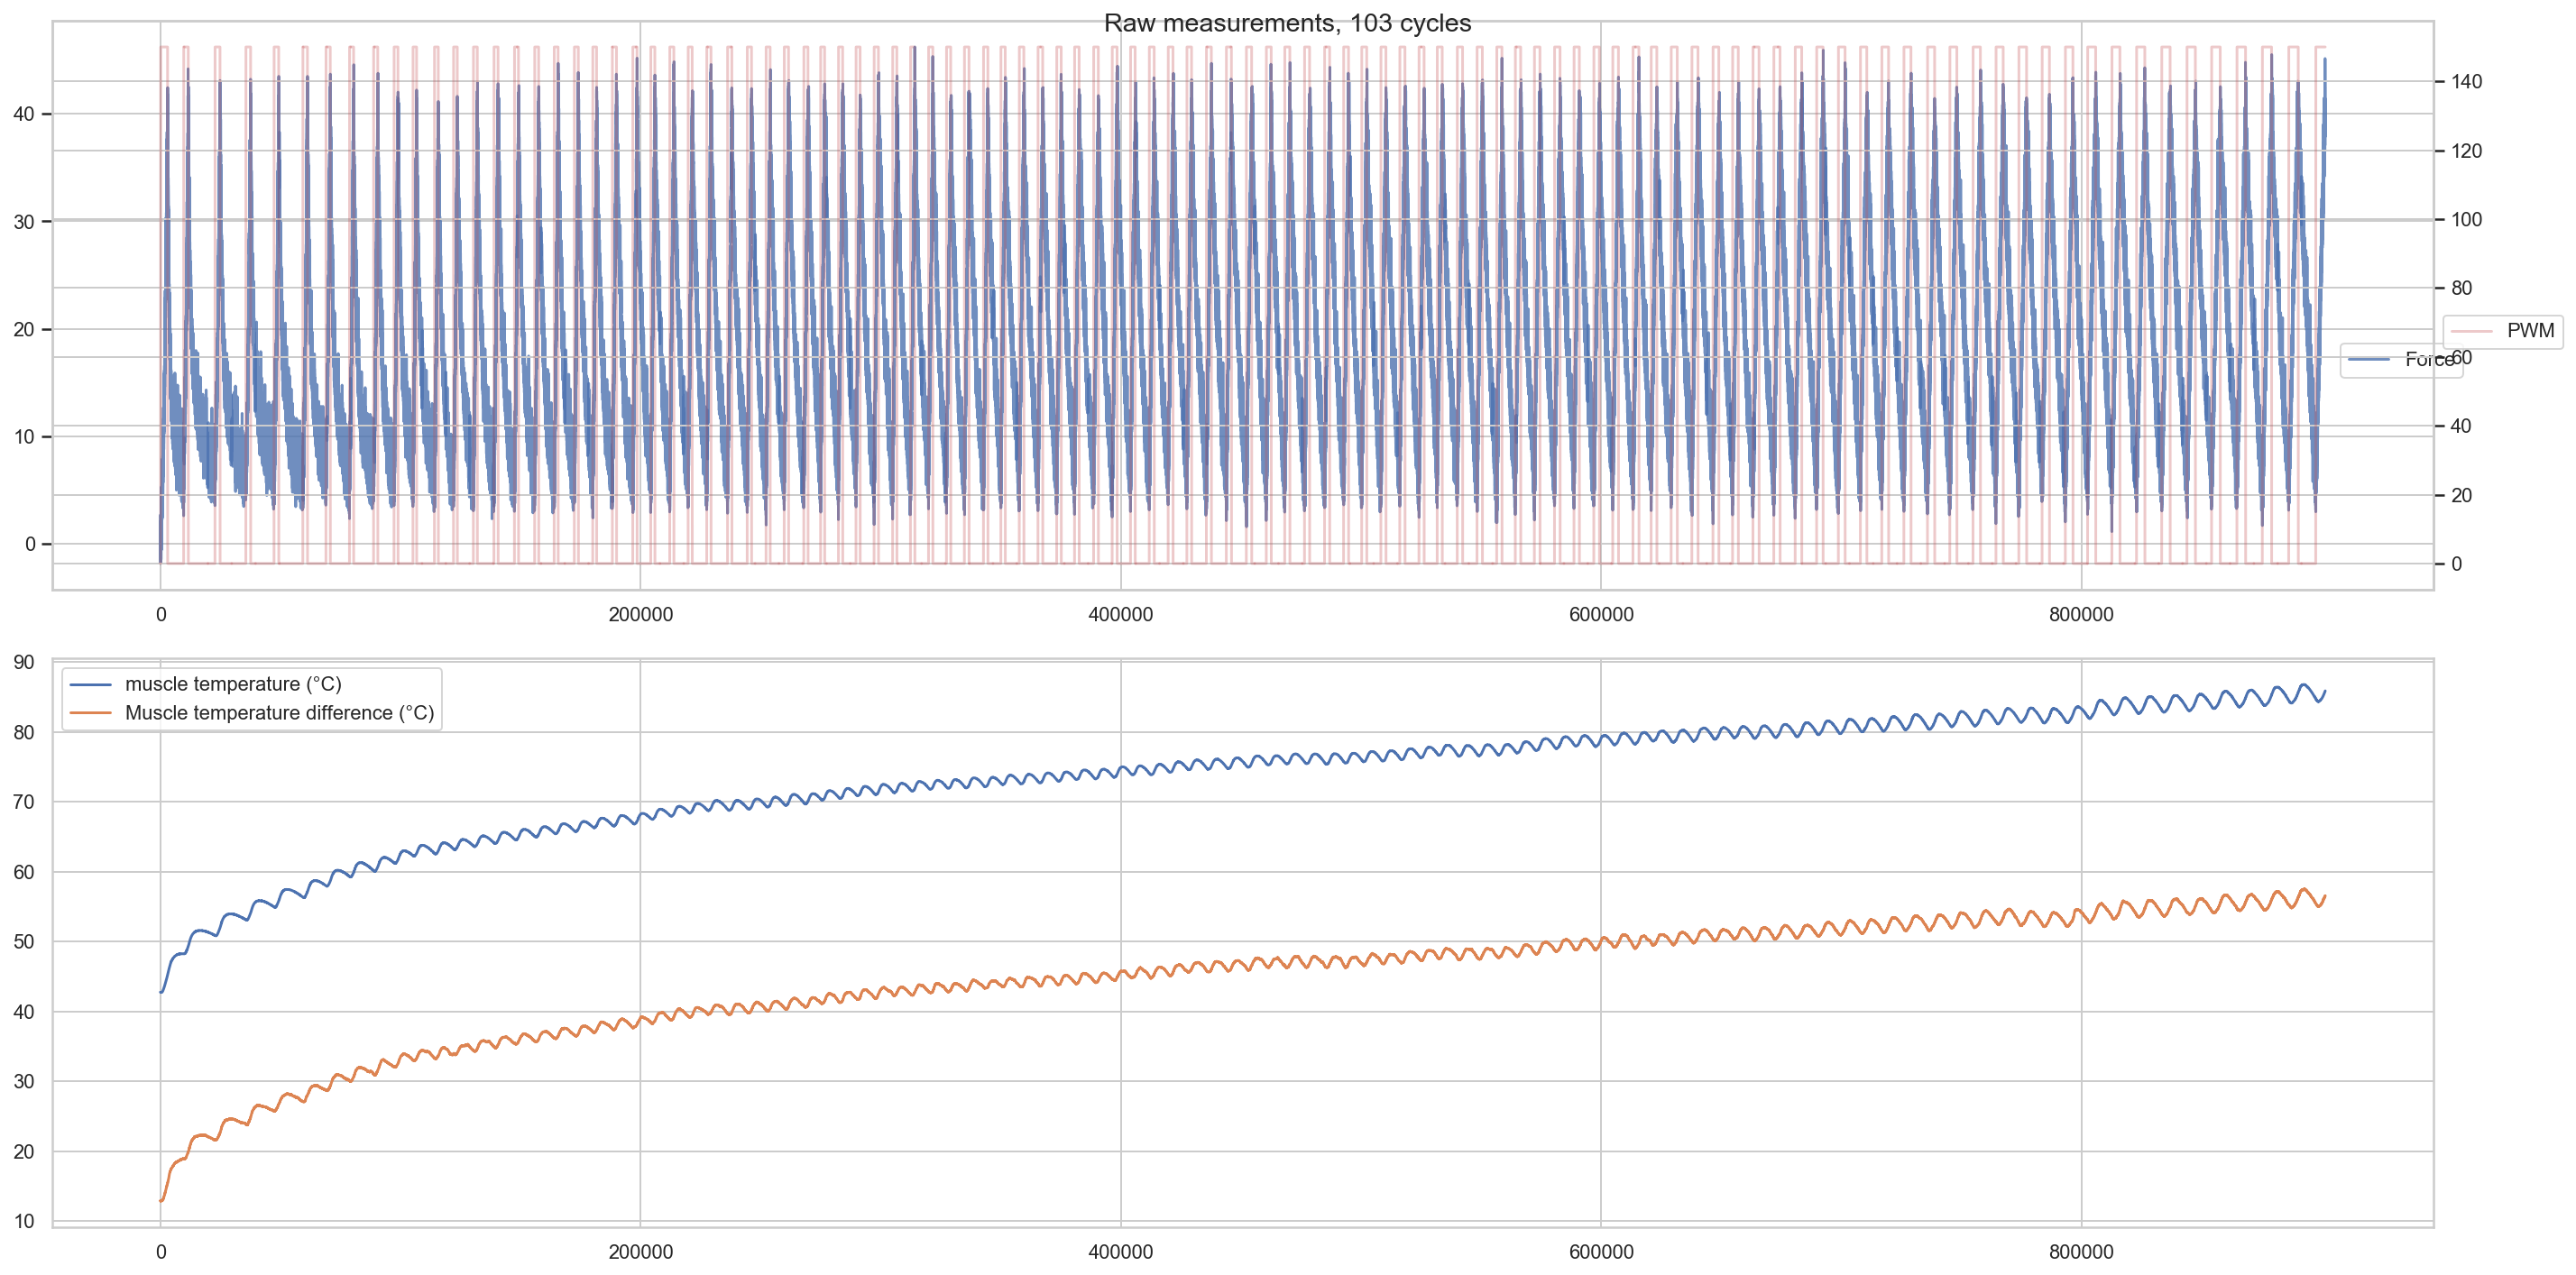

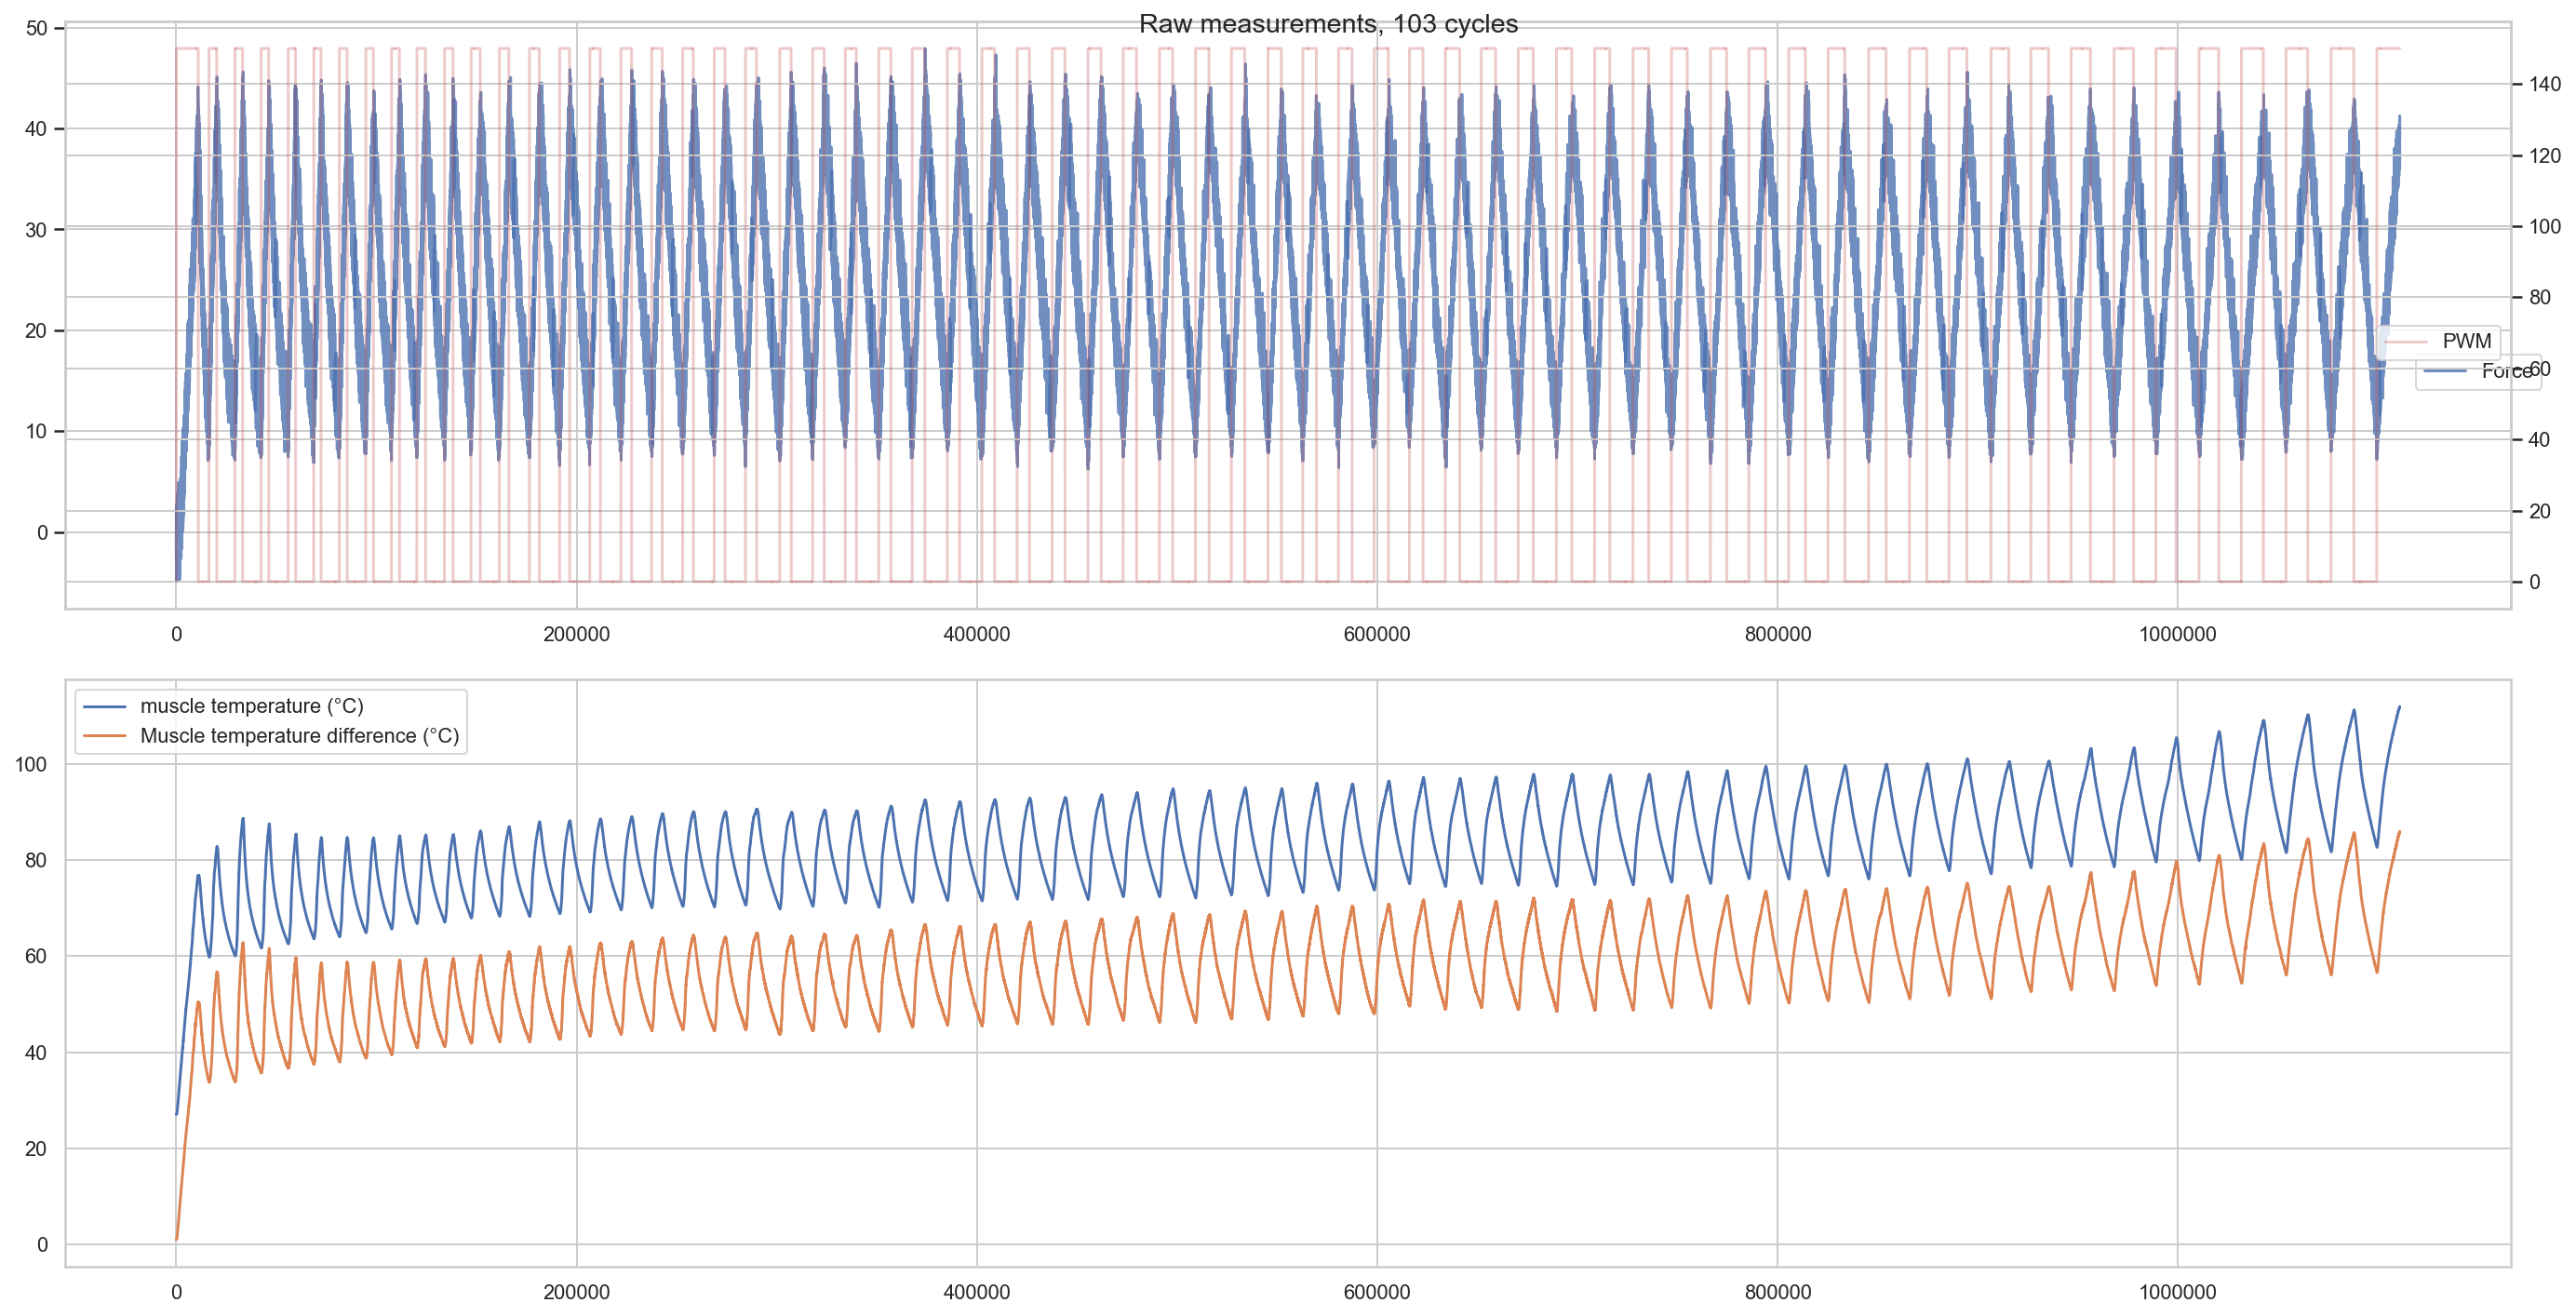

In [29]:
plot_raw(X100, n_cycles=103,savfig = "X103")
plot_raw(X61, n_cycles=61,savfig = "X61")

### Force-temperature correlation
Joint probabilities / Pearson correlation let us know whether a temperature-force relationship is worth investigating

In [30]:
def pickle_meta(df, name='df'):
    filename = 'meta_%s.pkl' % name
    # pickle data, if not already done so
    if not os.path.isfile(filename):
        minima, maxima = get_extrema(df, ra=True)
        abs_min, abs_max = get_extrema(df, order=3000, ra=False)
        df = label_cycles(df, minima, maxima, abs_min=abs_min, abs_max=abs_max)
        df.cycle = df.cycle.astype(np.int64)
        df_s, c_to_p = squash_periods(df)
        df_s.cycle = df_s.cycle.astype(np.int64)
        df.to_pickle(filename)
        df_s.to_pickle('meta_%sS.pkl' % name)

In [31]:
def ft_corr(df, df_s):
    if type(df.timestamp.iloc[0,]) != pd._libs.tslibs.timestamps.Timestamp: # convert to datetime timestamp, if necessary
        df.timestamp = df.timestamp.map(lambda t: datetime.fromtimestamp(t));
        df = df.set_index(pd.DatetimeIndex(df.timestamp), inplace=False);
    df_s.set_index(pd.DatetimeIndex(df_s.timestamp.map(lambda t: datetime.fromtimestamp(t))), inplace=True);
    season = int((df_s[df_s.cycle==1].shape[0])/0.1) #ms
    sns.jointplot(x=df_s.resample('%dL' % season).mean().t,\
              y=df_s.resample('%dL' % season).mean().f_ra, ratio=10)
    plt.show()
    return df, df_s

In [32]:
pickle_meta(X100, name='X100')
pickle_meta(X61, name='X61')

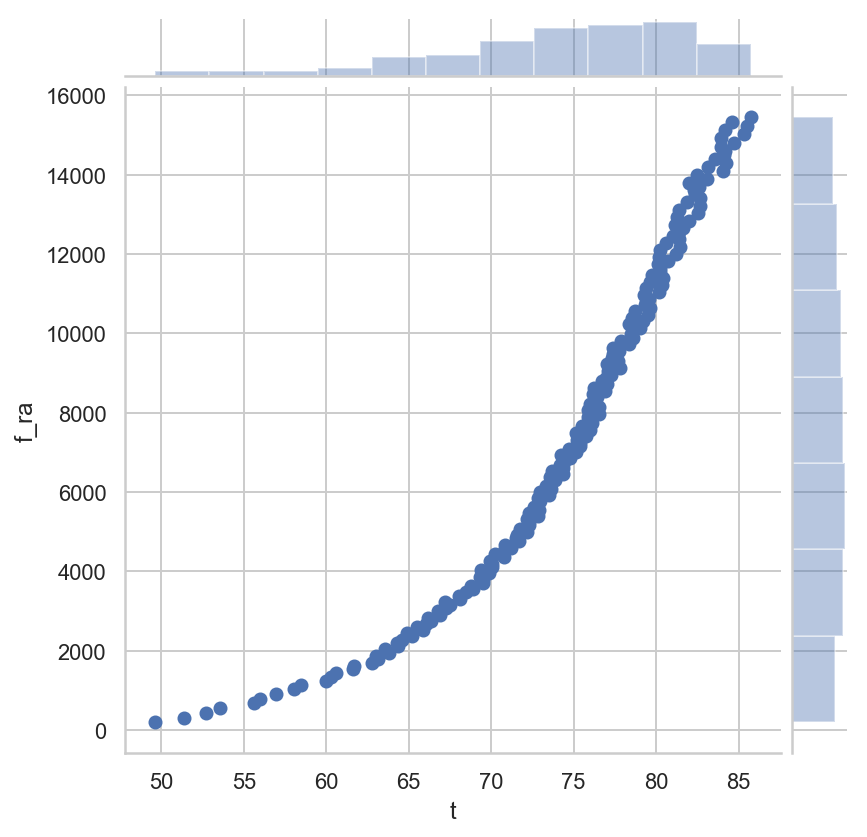

In [33]:
unpickled_df, unpickled_df_s = pd.read_pickle('meta_X100.pkl'), pd.read_pickle('meta_X100S.pkl')
X100, X100S = ft_corr(unpickled_df, unpickled_df_s)

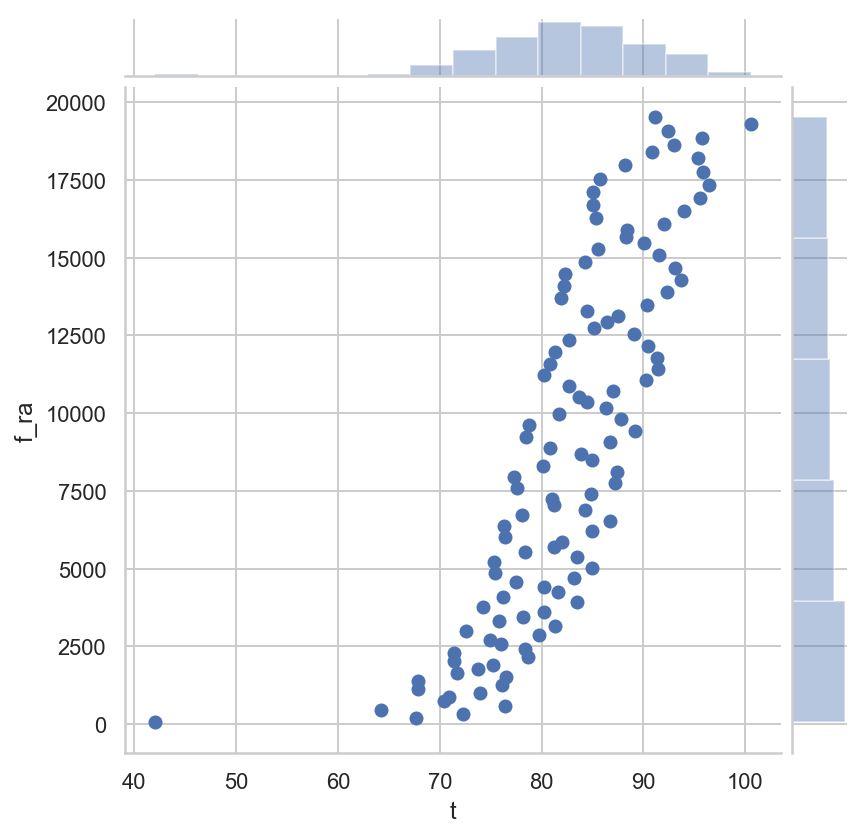

In [34]:
unpickled_df, unpickled_df_s = pd.read_pickle('meta_X61.pkl'), pd.read_pickle('meta_X61S.pkl')
X61, X61S = ft_corr(unpickled_df, unpickled_df_s)

### Train-test split

In [89]:
def train_val_test_split(df, ratio=0.8):
    data = np.apply_along_axis(lambda row: np.reshape(row, (1,-1)), 1, df.drop(columns=['timestamp','cycle']).values)
    train_cutoff, val_cutoff = int(ratio*ratio * data.shape[0]), int(ratio * data.shape[0])
    train, val, test = data[:train_cutoff,], data[train_cutoff:val_cutoff,], data[val_cutoff:,]
    train_X, train_y = train[:,:,1:], train[:,:,0].flatten()
    val_X, val_y = val[:,:,1:], val[:,:,0].flatten()
    test_X, test_y = test[:,:,1:], test[:,:,0].flatten()
    print("TRAIN_X: ", train_X.shape, " TRAIN_Y: ", train_y.shape)
    print("VAL_X: ", val_X.shape, " VAL_Y: ", val_y.shape)
    print("TEST_X: ", test_X.shape, " TEST_Y: ", test_y.shape)
    return train_X, train_y, val_X, val_y, test_X, test_y

### Supported so far:
`train_X, train_y, test_X, test_y = train_test_split(X61)`

`train_X, train_y, test_X, test_y = train_test_split(X103)`

In [101]:
X61.head()

,f,pwm,t,t0,timestamp,f_ra,cycle
timestamp,,,,,,,
1969-12-31 19:00:00.000000,-0.459416,0.0,27.079405,26.040293,1969-12-31 19:00:00.000000,0.0,-1
1969-12-31 19:00:00.019196,-1.446461,0.0,27.079405,26.040293,1969-12-31 19:00:00.019196,0.0,-1
1969-12-31 19:00:00.038605,0.028283,0.0,27.078402,26.042980,1969-12-31 19:00:00.038605,0.0,-1
1969-12-31 19:00:00.048553,-0.449492,0.0,27.078402,26.042980,1969-12-31 19:00:00.048553,0.0,-1
1969-12-31 19:00:00.058502,-0.417416,0.0,27.078402,26.042980,1969-12-31 19:00:00.058502,0.0,-1


In [90]:
train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X61)

TRAIN_X:  (710906, 1, 4)  TRAIN_Y:  (710906,)
VAL_X:  (177726, 1, 4)  VAL_Y:  (177726,)
TEST_X:  (222159, 1, 4)  TEST_Y:  (222159,)


In [91]:
np.unique(X61['cycle'].values)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], dtype=int64)

In [92]:
X61.head()

,f,pwm,t,t0,timestamp,f_ra,cycle
timestamp,,,,,,,
1969-12-31 19:00:00.000000,-0.459416,0.0,27.079405,26.040293,1969-12-31 19:00:00.000000,0.0,-1
1969-12-31 19:00:00.019196,-1.446461,0.0,27.079405,26.040293,1969-12-31 19:00:00.019196,0.0,-1
1969-12-31 19:00:00.038605,0.028283,0.0,27.078402,26.042980,1969-12-31 19:00:00.038605,0.0,-1
1969-12-31 19:00:00.048553,-0.449492,0.0,27.078402,26.042980,1969-12-31 19:00:00.048553,0.0,-1
1969-12-31 19:00:00.058502,-0.417416,0.0,27.078402,26.042980,1969-12-31 19:00:00.058502,0.0,-1


In [98]:
train_X.shape

(710906, 1, 4)

In [83]:
np.unique(X61['f_ra'])

array([-1.69058278, -1.68846273, -1.68563422, ..., 42.13617894,
       42.13654381, 42.13654429])

In [ ]:
X61['']

### LSTM
Time-series/sequential problem. Framing this as a supervised learning problem:

Given temperature $ T $ at current time $ t $, and force (N) $f$, $T$ at $0...(t-1)$,
predict $f$ at $t$

In [71]:
name = 'X61'

In [72]:
def load_model(name):
    # load json and create model
    json_file = open('%s.json' % name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights('%s.h5' % name)
    return loaded_model
model = load_model(name)

In [73]:
def save_model(model, name='X100'):
#     if not os.path.isfile('%s.json' % name) or not os.path.isfile('%s.h5' % name):
    model_json = model.to_json()
    with open('%s.json' % name, 'w') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('%s.h5' % name)
    model.save('%s.hdf5' % name)
save_model(model, name='X61')        

### Run model

In [93]:
def train(name, start_over=False): # set start_over=True if you want to retrain the model & overwrite all weights
    if not os.path.isfile('%s.hdf5' % name) or start_over:
        model = Sequential()
        model.add(CuDNNLSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history = model.fit(train_X, train_y, epochs=40, batch_size=2000,\
                            validation_data=(val_X, val_y), verbose=2, shuffle=False)
        save_model(model, name)
    else:
        model = load_model(name) ###?
        history = None
    return model,history

In [94]:
model,history = train('X61', start_over=True)

Train on 710906 samples, validate on 177726 samples
Epoch 1/40
 - 3s - loss: 249.4072 - val_loss: 89.2456
Epoch 2/40
 - 2s - loss: 46.8720 - val_loss: 21.5957
Epoch 3/40
 - 2s - loss: 15.1136 - val_loss: 6.9272
Epoch 4/40
 - 2s - loss: 8.3475 - val_loss: 3.7342
Epoch 5/40
 - 2s - loss: 6.7738 - val_loss: 2.7059
Epoch 6/40
 - 2s - loss: 5.9854 - val_loss: 1.9450
Epoch 7/40
 - 2s - loss: 5.6780 - val_loss: 1.6374
Epoch 8/40
 - 2s - loss: 5.5891 - val_loss: 1.8976
Epoch 9/40
 - 2s - loss: 6.0169 - val_loss: 3.3054
Epoch 10/40
 - 2s - loss: 5.2425 - val_loss: 1.4455
Epoch 11/40
 - 2s - loss: 5.0529 - val_loss: 6.6117
Epoch 12/40
 - 2s - loss: 5.3261 - val_loss: 1.7643
Epoch 13/40
 - 2s - loss: 4.5118 - val_loss: 1.2856
Epoch 14/40
 - 2s - loss: 4.8419 - val_loss: 3.3422
Epoch 15/40
 - 2s - loss: 4.4851 - val_loss: 1.3815
Epoch 16/40
 - 2s - loss: 4.5501 - val_loss: 1.3084
Epoch 17/40
 - 2s - loss: 4.4510 - val_loss: 3.5646
Epoch 18/40
 - 2s - loss: 4.2738 - val_loss: 1.4705
Epoch 19/40
 - 

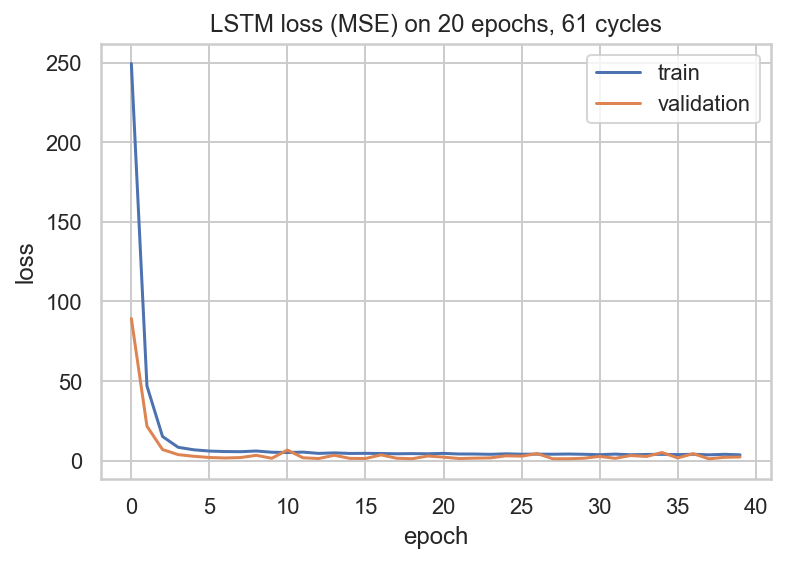

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss (MSE) on %d epochs, %d cycles' % (20, 61))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [99]:
test_X.shape

(222159, 1, 4)

In [96]:
yhat = model.predict(test_X)

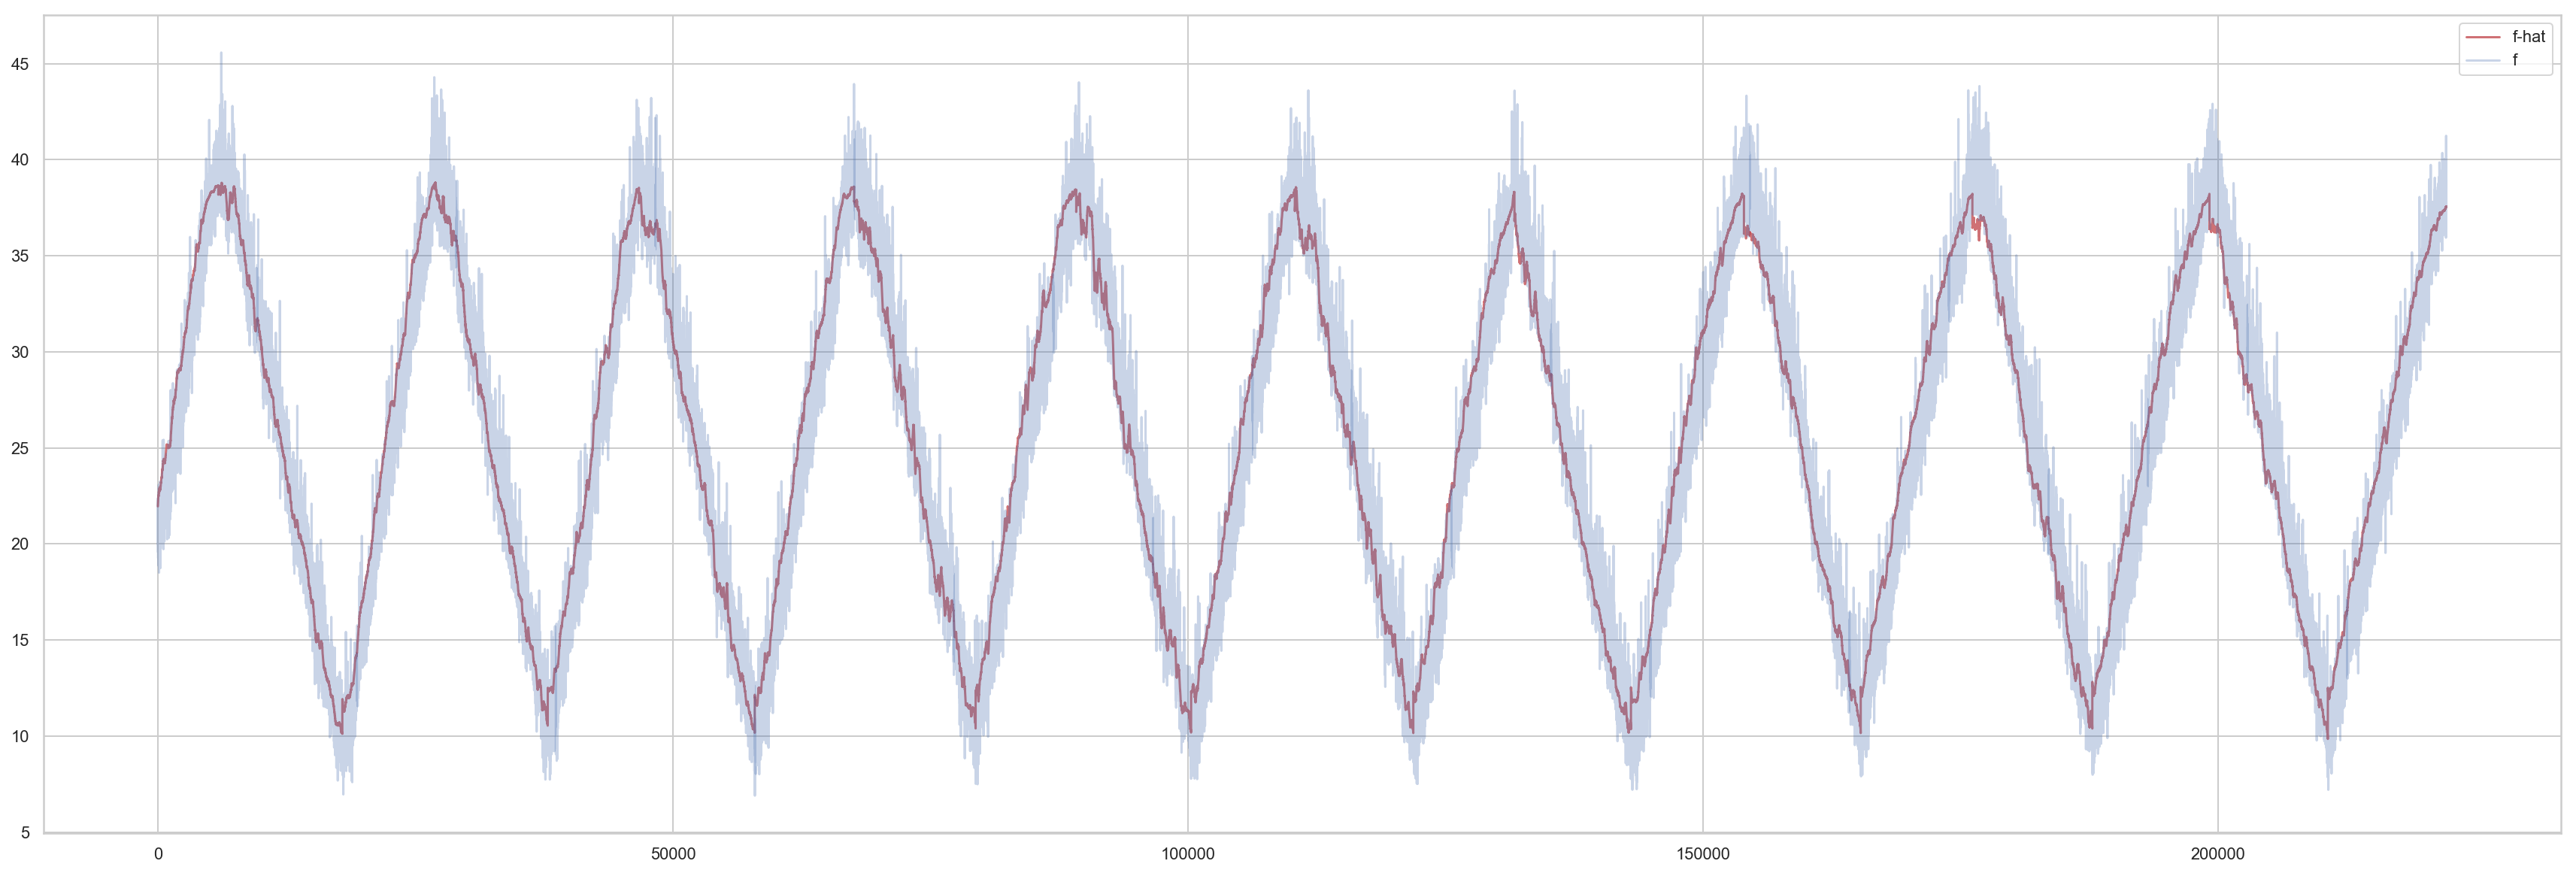

In [97]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(yhat, alpha=0.8, c='r', label='f-hat')
ax.plot(test_y, alpha=0.3, c='b', label='f')
plt.legend()
plt.show()